In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qmmc.structure2 import *

## Generate data from a model

In [3]:
# Hyperpriors
mu_0, sigma_0 = Value(0), Value(.5)
scale_0, shape_0 = Value(10), Value(10)
n = Value(1000)

# Priors and variables
mu_real = Normal(mu_0, sigma_0, name='mu_real')
sigma_real = InvGamma(scale_0, shape_0, name='sigma_real')
V_real = Normal(mu_real, sigma_real, size=n.value, name='V_real')
W_real = Normal(mu_real, sigma_real, size=n.value, name='W_real')


@Function
def S_real(V=V_real, W=W_real):
    d = np.array(V > W, dtype=int)
    return d

p = Value(0.01)
I_real = BernoulliFlip(p, S_real)

In [4]:
print mu_real.value
print sigma_real.value
print S_real.value[:20]
print I_real.value[:20]

0.338561476594
0.854106710348
[1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0]
[1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0]


## Estimate model parameters from data

In [5]:
# Priors and variables
mu = Normal(mu_0, sigma_0, value=mu_real.value + 2, name='mu')
sigma = InvGamma(scale_0, shape_0, value=sigma_real.value + 2, name='sigma')
V = Normal(mu, sigma, value=V_real.value, observed=True, name='V')
W = Normal(mu, sigma, size=n.value, name='W')

@Function
def S(V=V, W=W):
    d = np.array(V > W, dtype=int)
    return d

p = Value(0.01)
I = BernoulliFlip(p, S, value=I_real.value, observed=True, name='I')

In [6]:
model = Model([mu, sigma, V, W, S, I])

In [7]:
model.estimate(40000)

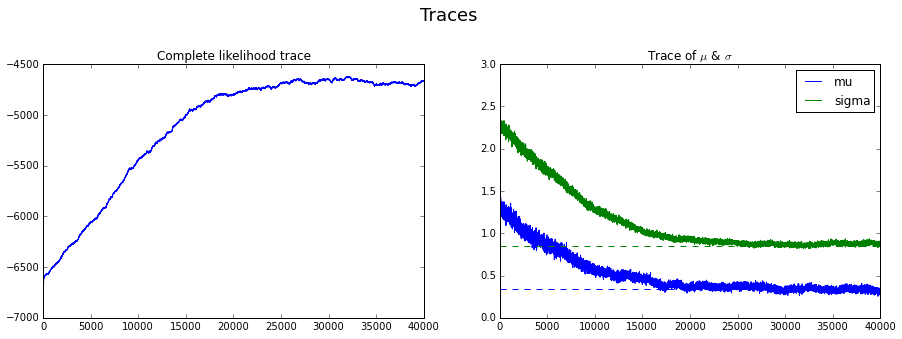

In [8]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(model.logp_history)
plt.title("Complete likelihood trace")

plt.subplot(2, 2, 2)
plt.plot(model.samplers['mu'].get_history())
plt.plot(model.samplers['sigma'].get_history())
plt.axhline(mu_real.value, linestyle='--')
plt.axhline(sigma_real.value, color='g', linestyle='--')
plt.legend(["mu", "sigma"], loc='best')
plt.title(r"Trace of $\mu$ & $\sigma$")

plt.suptitle(r"Traces", size=18)
plt.show()